# Rules of the "DICE" game: You get a dollar shown by the face value of the dice. You can play as long as you want, but you get 0, nothing, if a 1 is rolled and the game is over. Questions: 
 ## What is the optimal number of times to roll?
 ## What is the probability distribution of the payoff after a number of dice rolls?

Let's do some Monte Carlo simulations: 

In [4]:
import random

max_rounds = 50
num_trials = 10000
expected_money_per_game = []
for num_rounds in range(1, max_rounds):
    expected_money = 0
    for game in range(num_trials):
        money = 0
        for game_round in range(num_rounds):
            result = random.randint(1,6)
            money += result
            if result == 1:
                money = 0
                break
        expected_money += money

    expected_money /= num_trials
    #print(expected_money)
    expected_money_per_game.append(expected_money)

Now lets compute the expected returns. The expectation value of the game is: (2+3+4+5+6 / 5) = 4 dollars per game, If a 1 is not rolled. In this case you get zero. The probablity of getting a non zero amount is p(x) = 5/6. After n rolls it is: (5/6)^n * 4n

In [19]:
import math

theory_expected_money_per_game = []
for num_rounds in range(1, max_rounds):
    theory_expected_money = math.pow((5.0/6.0), num_rounds) * 4.0 * num_rounds
    theory_expected_money_per_game.append(theory_expected_money)
#print(theory_expected_money_per_game)

Lets overlay the Monte Carlo simulations with the theory:

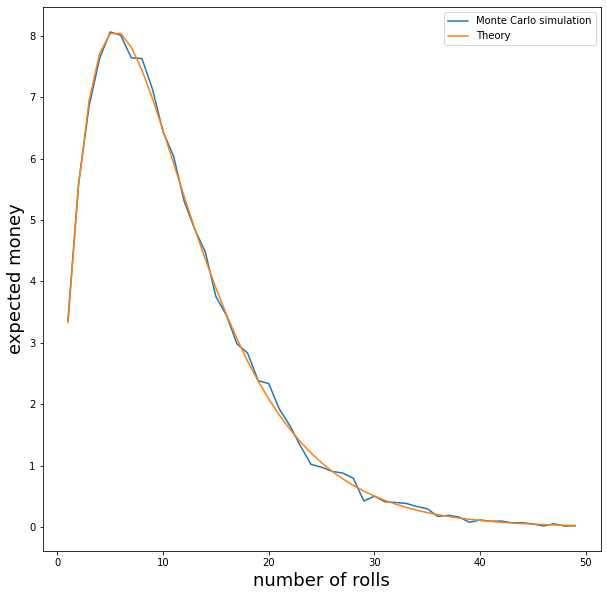

In [46]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, axis = plt.subplots(1,1, figsize=(10,10))

axis.plot(range(1,max_rounds), expected_money_per_game, label='Monte Carlo simulation')
axis.plot(range(1,max_rounds), theory_expected_money_per_game, label='Theory')
axis.set_xlabel('number of rolls', fontsize=18)
axis.set_ylabel('expected money', fontsize=18)
axis.legend()

plt.show()

Perfect match! Looks like the theroy is spot on. What if I try another approach? Let's say I select a target amount of money at which point I stop playing. Playing forever will always result in 0 dollars.

In [ ]:
import random

num_trials = 10000
target_monies = 4 * 50
expected_monies = []
for target_money in range(1, target_monies):
    expected_money = 0
    for game in range(num_trials):
        money = 0
        while money < target_money:
            result = random.randint(1,6)
            money += result
            if result == 1:
                money = 0
                break
        expected_money += money

    expected_money /= num_trials
    expected_monies.append(expected_money)
    #print(target_money, expected_money)


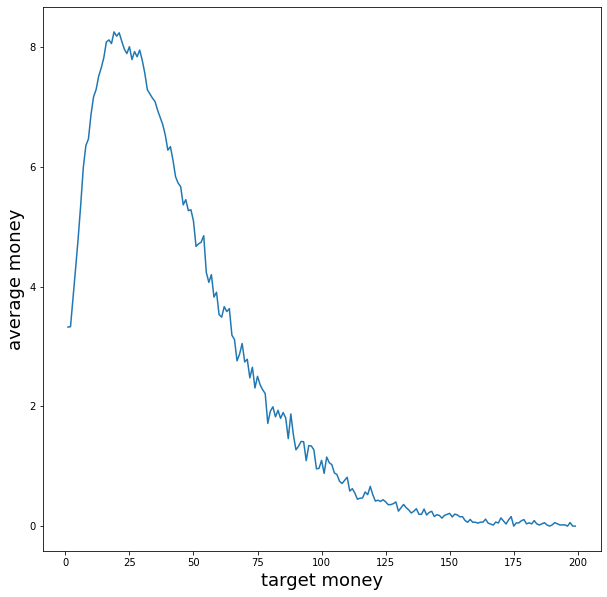

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, axis = plt.subplots(1,1, figsize=(10,10))

axis.plot(range(1, target_monies), expected_monies)
axis.set_xlabel('target money', fontsize=18)
axis.set_ylabel('average money', fontsize=18)

plt.show()

Lets see how this comapres to the stratgy where we slect a number of games to play. First we have to normalize the target money by the expectation value per game.

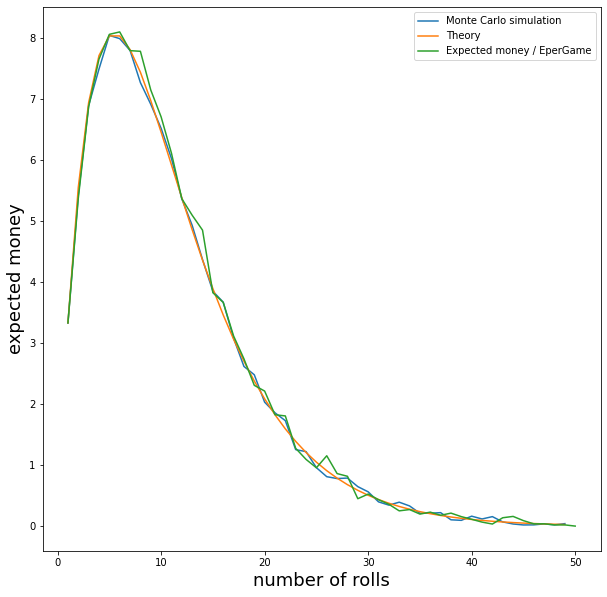

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, axis = plt.subplots(1,1, figsize=(10,10))

expectation_value = 4
expected_monies_norm = expected_monies[1::expectation_value]
target_monies_norm = len(expected_monies_norm) + 1

axis.plot(range(1,max_rounds), expected_money_per_game, label='Monte Carlo simulation')
axis.plot(range(1,max_rounds), theory_expected_money_per_game, label='Theory')
axis.plot(range(1, target_monies_norm), expected_monies_norm, label='Expected money / EperGame')
axis.set_xlabel('number of rolls', fontsize=18)
axis.set_ylabel('expected money', fontsize=18)
axis.legend()

plt.show()

## Looks the same to me. The optimum number or rolls is 5-6 times. Alternatively we can choose to target 20 - 25 dollars of winnings.   If I were to setup such a game in a casino I'd be sure to charge > 8 dollars per game to ensure an expected profit. This answers question #1

## Let's see if we can compute the PMF of the winnings, if we win

Can we calculate the PDF? The naive solution is to use a multinomial distribution, but that has (n + k -1) choose (k - 1) different combinations. In otherwords the complexity of the problem is factorial. However if one considers that there is 2n to 6n discrete values in the PMF, that is not factorial, but linear. There must be significant overlap in the subproblems. Might a dynamic programming (DP) solution exist? Let's see if optimal substructure exists. If one considers two die roles then  there of 5 ways of computing 8: 2+6, 3+5, 4+4, 5+3, and 6+2. This grows exponentially with the number of rolls. Once we know a base case we can add another roll to it. Let's consider two rolls: The possible values are 4,5,6,7,8,9,10,11,12. There is one way to make 4: (2,2), two ways to make 5: (2,3) and (3,2), and three ways to make 6: (2+4), (3+3), and (4+2). Now consider the third roll: we can make 6,7,8, ..., 18. How may ways are there to make 6? It's only 4+2 and since there is only one way to make 4, there is also only one way to make 6: (2,2,2). Now consider 7: 5+2, and 4+3. In the second round there were 2 ways of making 5 and 1 way of making 4 so there must be 2+1 ways of making 7. To drive the point home consider 8: There are three ways of making 8: 6+2, 5+3, and 4+4. In the second round there were three ways of making 6, two ways of making 5 and one way of making 4, so there must be 3+2+1=6 ways of making 8 in round 3. Since there is both subproblem overlap and optimnal substructure, Let's write a dynamic programming solution below: 

This is appears to be a generalization of Pascal's triangle. Rather than summing the two diagonal neighbors on the previous row, k neighbors on the previous row are summed.

In [2]:
def compute_pmf(dice_values, PMF_k):
    PMF_k_1 = {} 
    for value in dice_values:
        for sum_k, ways_k in PMF_k.items():
            sum_k_1 = sum_k + value
            if sum_k_1 in PMF_k_1:
                PMF_k_1[sum_k_1] += ways_k
            else:
                PMF_k_1[sum_k_1] = ways_k 
    return PMF_k_1

In [3]:
# Base case
dice_values = [2, 3, 4, 5, 6]
PMF_k = {dice_values[0]:1, dice_values[1]:1, dice_values[2]:1, dice_values[3]:1, dice_values[4]:1} 

# let roll the dice
max_rolls = 5
PMF_k_1 = PMF_k
for roll in range(1, max_rolls):
    PMF_k_1 = compute_pmf(dice_values, PMF_k_1)
    
#print(PMF_k_1)

In [36]:
import numpy as np
# Lets normalize the data to grate a proper PMF what intergrates to 1.0 
total_permutations = math.pow(5, max_rolls)

probs_money = []
for k, v in PMF_k_1.items():
    probs_money.append([k, (float(v) / total_permutations)])
probs_money = np.array(probs_money)

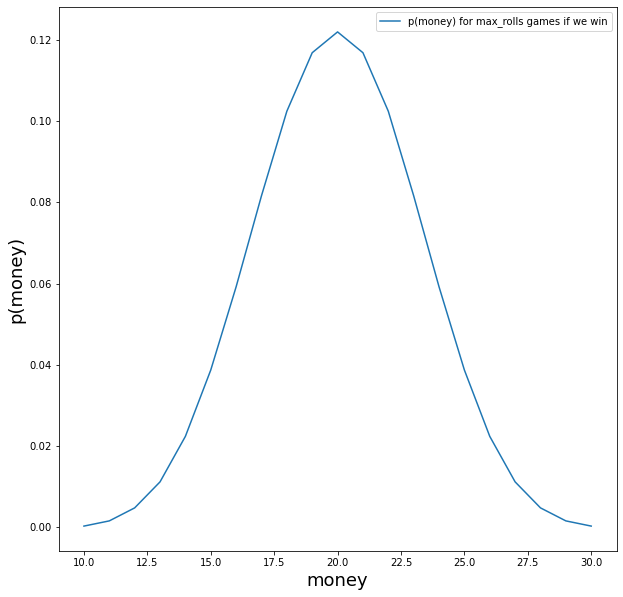

In [55]:
import matplotlib.pyplot as plt
import math
%matplotlib inline

fig, axis = plt.subplots(1,1, figsize=(10,10))
axis.plot(probs_money[:,0], probs_money[:,1], label="p(money) for max_rolls games if we win")
axis.set_xlabel('money', fontsize=18)
axis.set_ylabel('p(money)', fontsize=18)
axis.legend()

plt.show()

Looks like a bell curve showing the probablity of money after 'n' games. This assumes we don;t roll a one and lose. I wonder what the variance is? We can integrate this curve to find the probs for any range of money :)

To compute the probablity of money in total, win or lose, then we need to multiple the probs by (5.0/6.0)^max_rolls and add in the zero case.

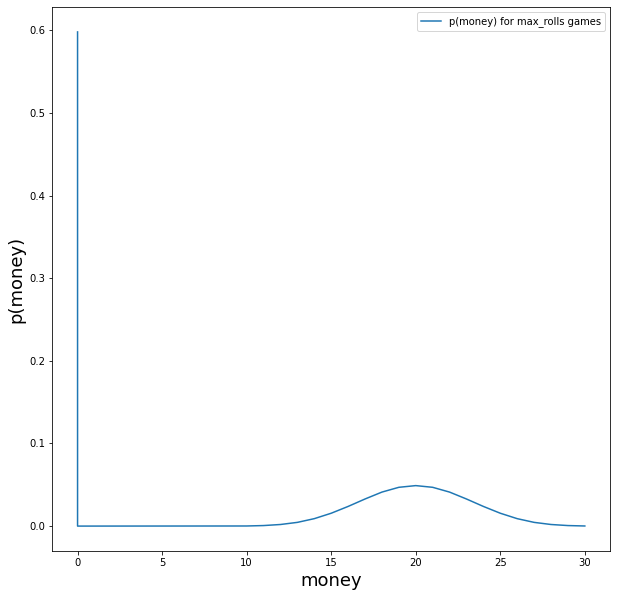

In [56]:
import matplotlib.pyplot as plt
import math
import numpy as np
%matplotlib inline

probs_money_total = np.concatenate((np.array([[0,0],[0,0]]), probs_money))
prob_winning = math.pow((5.0/6.0), max_rolls)
probs_money_total[:,1] *= prob_winning
probs_money_total[0,1] = 1.0 - prob_winning

fig, axis = plt.subplots(1,1, figsize=(10,10))

axis.plot(probs_money_total[:,0], probs_money_total[:,1], label="p(money) for max_rolls games")
axis.set_xlabel('money', fontsize=18)
axis.set_ylabel('p(money)', fontsize=18)
axis.legend()

plt.show()

In [59]:
print(np.sum(probs_money_total[:,1]))
print(np.sum(probs_money_total[:,1] * probs_money_total[:,0]))

0.9999999999999999
8.037551440329219
